# Chapter 14 – Recurrent Neural Networks - 递归神经网络

击球手击球。你立即开始跑，并预测折球的轨迹。你跟踪它并调整你的动作，最后抓住它（在掌声雷动之下）。预测未来是你一直在做的事情，无论你是在完成一个朋友的判决还是在早餐时预测咖啡的味道。在本章中，我们将讨论递归神经网络（RNN），这是一类可以预测未来的网络（当然，直到某一点）。
* 他们可以分析时间序列数据，如股票价格，并告诉你何时买入或卖出。
* 在自动驾驶系统中，他们可以预测汽车轨迹并帮助避免事故。

更普遍的，**它们可以处理任意长度的序列**，而不是像我们迄今为止讨论过的所有网络那样固定大小的输入。例如，他们可以将句子，文档或音频样本作为输入，使其对自然语言处理（NLP）系统非常有用，例如自动翻译，语音到文本或情感分析（例如，阅读电影评论并提取评论者对电影的感受）。


此外，**RNN的预期能力也使他们具有令人惊讶的创造力**。你可以要求他们预测旋律中最有可能的下一个音符，然后随机选择其中一个音符并播放。然后向网络询问下一个最可能的音符，播放它，并一次又一次地重复该过程。在你知道之前，你的网络将构成一个旋律，例如由Google的Magenta项目制作的旋律。同样，RNN可以生成句子，图像标题等等。结果并不完全是莎士比亚或莫扎特，但谁知道他们将在几年后产生什么呢？

在这一章当中，我们将
* 研究RNN背后的基本概念，即它们面临的主要问题（即第11章讨论的梯度消失/爆炸），
* 以及广泛用于对抗它的解决方案：**LSTM和GRU细胞**。

* 我们将一如既往地展示如何使用TensorFlow实现RNN。
* 最后，我们将看一下机器翻译系统的架构。

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "14_RNN"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# 1. Recurrent Neurons - 递归神经元

到目前为止，我们主要关注前馈神经网络，激活仅在一个方向上流动，从输入层到输出层（附录E中的少数网络除外）。递归神经网络看起来非常像前馈神经网络，除了它还有向后指向的连接。

让我们看一下最简单的RNN，它只由一个接收输入的神经元组成，产生一个输出，并将该输出发送回自身，如图14-1（左）所示。在每个时间步 $t$（也称为帧），该**递归神经元**接收输入$x_{(t)}$ 以及来自前一时间步$y_{(t-1)}$的其自己的输出。

我们可以在时间轴上表示这个小网络，如图14-1（右）所示。这称为**通过时间展开网络**。

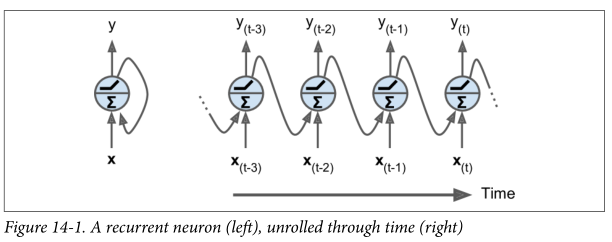

你可以轻松创建一层递归神经元。在每个时间步 $t$ ，每个神经元接收输入向量 $x_{(t)}$和前一时间步 $y_{(t-1)}$的输出向量，如图14-2所示。请注意，**输入和输出现在都是向量**（当只有一个神经元时，输出是标量）。

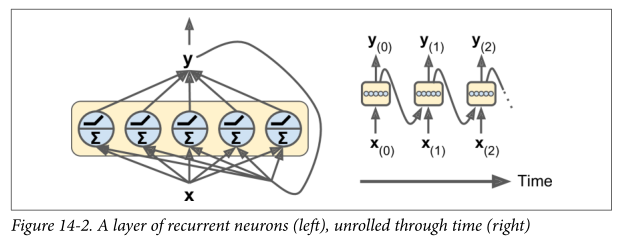

每个递归神经元具有两组权重：一组用于输入$x_{(t)}$，另一组用于前一时间步的输出$ y_{(t-1)}$。我们称这些为权重向量$w_x$和 $w_y$。一个递归神经元的输出可以像你所期望的那样计算出来如公式14-1所示（%b$是偏置项，$φ(·)$是激活函数，例如ReLU ）。

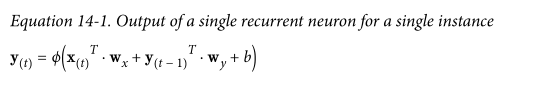

就像前馈神经网络一样,我们可以使用前一个等式的向量化形式一次性计算整个小批量的整个层的输出（见公式14-2）。
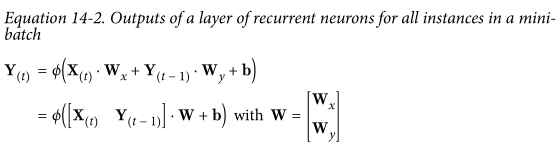

* 对于小批量中的每个实例，$Y_{(t)}$ 是 $m × n_{neurons}$矩阵，其包含每个时间步长 $t$ 的层输出（$m$ 是小批量中的实例数，$n_{neurons}$ 是神经元的数量）。


* $X_{(t)}$ 是一个$m × n_{inputs}$矩阵，包含所有实例的输入（$ n_{inputs}$是输入特征的数量）。

* $W_x$ 是一个$ n_{inputs}× n_{neurons}$矩阵,包含当前时间步输入的连接权重


* $W_y$ 是$ n_{neurons}× n_{neurons}$矩阵，其包含前一时间步的输出的连接权重。

* 权重矩阵$W_x$和$W_y$通常被连接成形状为$(n_{inputs}× n_{neurons})× n_{neurons}$的单个权重矩阵 $W$ （参见等式14-2的第二行）。

* $b$ 是大小为 $n_{neurons}$ 的向量，包含每个神经元的偏差项。

注意:
* $Y_{(t)}$ 是 $X_{(t)}$ 和 $Y_{(t-1)}$ 的函数，
* $Y_{(t-1)}$ 是 $X_{(t-1)}$ 和 $Y_{(t-2)}$ 的函数，
* $Y_{(t-2)}$ 是 $X_{(t-2)}$ 和 $Y_{(t-3)}$ 的函数，

依此类推。 这使得$Y_{(t)}$ 是从时间 $t = 0$ 开始的所有输入的函数(即，$X_{(0)}$，$X_{(1)}$，...，$X_{(2)}$)。

在第一个时间步， $t = 0$ ，没有先前的输出，因此**通常假定它们全为零**。

## 1.1  Memory Cells - 记忆细胞

由于在时间步 $t$ 的递归神经元的输出是来自先前时间步的所有输入的函数，你可以说它有一种记忆形式。跨时间步保留某些状态的神经网络的一部分称为**记忆单元**（或简称为单元）。单个递归神经元或一层递归神经元是一个非常基本的细胞，但在本章后面我们将讨论一些更复杂和更强大的细胞类型。


通常，在时间步 $t$ 处的单元状态，表示为$h_{(t)}$（$“h”$代表“隐藏”），是该时间步的一些输入及其在前一时间步的状态的函数：$ h_{(t)}= f(h_{(t-1)}，x_{(t)})$。 其在时间步长t的输出，表示为$y_{(t)}$，也是先前状态和电流输入的函数。

在我们到目前为止讨论的基本单元的情况下，输出简单地等于状态，但在更复杂的单元中，情况并非总是如此，如图14-3所示。

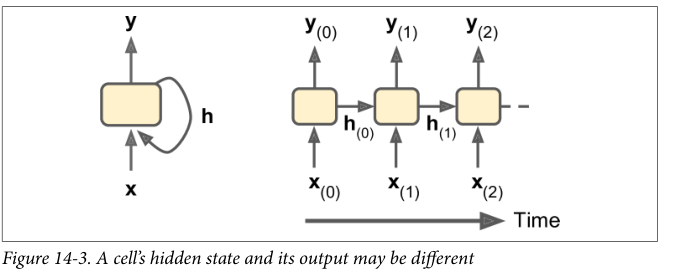

## 1.2  Input and Output Sequences - 输入和输出序列

* RNN可以同时获取一系列输入并产生一系列输出（见图14-4，左上角网络）。例如，这种类型的网络可**用于预测时间序列**，例如股票价格：你在过去 $N$ 天喂它的价格，它必须将价格转移到未来一天（即从$N - 1$天前到明天）。


* 或者，你可以为网络提供一系列输入，并忽略除最后一个输出之外的所有输出（请参见右上角网络）。换句话说，这是一个**序列—向量网络**。例如，你可以向网络提供对应于电影评论的一系列单词，并且网络将输出情绪分数（例如，从-1 [仇恨]到+1 [爱]）。

反过来，你可以在第一个步骤为网络提供**单个输入**（并为所有其他时间步骤提供零），并让它**输出一个序列**（请参见左下角网络）。这是一个**向量-序列网络**。例如，输入可以是图像，输出可以是该图像的标题。

最后，你可以使用称为**编码器**的序列-向量网络，然后是称为**解码器**的向量-序列网络（请参见右下角网络）。例如，这可以用于将句子从一种语言翻译成另一种语言。你可以用一种语言为网络提供一个句子，

* 编码器将该句子转换成单个向量表示，
* 解码器将该向量解码成另一种语言的句子。

这个两步模型称为**编码器 - 解码器**，比使用单个序列到序列的RNN进行动态转换要好得多（就像左上角所示的那个），因为句子的最后一个单词可以影响翻译的第一个单词，所以你需要等到你在翻译之前听到整个句子。

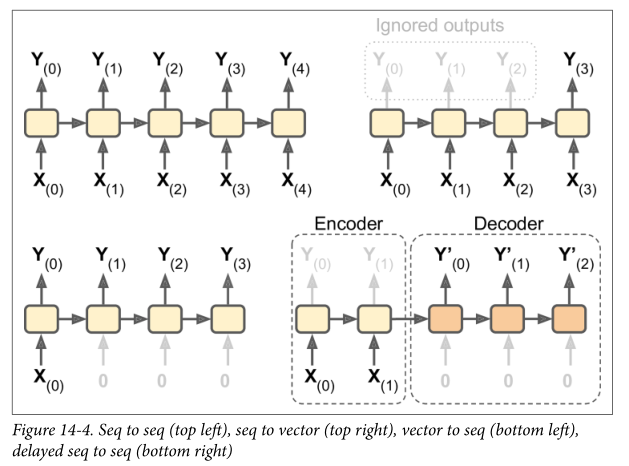

听起来很有希望，让我们开始编码吧！

# 2. Basic RNNs in TensorFlow

**首先**，让我们实现一个非常简单的RNN模型，**不使用任何TensorFlow的RNN操作，以更好地理解底层的内容**。
* 我们将使用tanh激活函数创建由五个递归神经元（如图14-2中所示的RNN）组成的RNN。
* 我们假设RNN仅运行两个时间步长，在每个时间步长处获取大小为3的输入向量。

以下代码构建此RNN，通过两个时间步骤展开：

** Manual RNN - 手写RNN **

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

这个网络看起来很像一个双层前馈神经网络，有几个变化：

* 首先，两个层共享相同的权重和偏差项，
* 第二，我们在每一层投喂输入，我们从每一层获得输出。

要运行模型，我们需要在两个时间步为它提供输入，如下所示：

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})


* 这个小批量包含四个实例，
* 每个实例都有一个**由两个输入组成的输入序列**。
* 最后，`Y0_val`和`Y1_val`包含小批量中所有神经元和所有实例的两个时间步的网络输出：


In [5]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


那不是太难,但是当然如果你希望能够运行超过100个时间步长的RNN，那么图表将会非常大。

现在让我们看看如何**使用TensorFlow的RNN操作创建相同的模型**。


## 2.1  Static Unrolling Through Time - 静态展开时间

`static_rnn（）`函数通过链接单元格来创建展开的RNN网络。以下代码创建与前一个完全相同的模型：

** Using `static_rnn()`**

In [5]:
n_inputs = 3
n_neurons = 5

In [6]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

* 首先，我们像以前一样创建输入占位符。

* 然后我们创建一个`BasicRNNCell`，你可以将其**视为一个工厂**，它创建单元格的副本以构建展开的RNN（每个时间步长一个）。

* 然后我们调用`static_rnn（）`，给它**单元工厂**和**输入张量**，并告诉它输入的**数据类型**（这用于创建初始状态矩阵，默认情况下为零）。
    * static_rnn（）函数每个输入调用一次单元工厂的 `__call __（）`函数，创建两个单元格的副本（每个包含一个由五个递归神经元组成的层），具有共享权重和偏置项，并且它就像我们之前做的那样链接它们。

    * static_rnn（）函数**返回两个对象**。第一个是包含每个时间步的**输出张量的Python列表**。第二个是包含网络**最终状态**的张量。当你使用基本单元格，最终状态简单地等于最后一个输出。


In [7]:
init = tf.global_variables_initializer()

In [8]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [9]:
Y0_val

array([[ 0.30741337, -0.32884312, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.9912275 , -0.95425415, -0.7518078 , -0.9995208 ,  0.98202336],
       [ 0.99992675, -0.99783254, -0.82473516, -0.99999636,  0.99947786],
       [ 0.9967709 , -0.6875061 ,  0.8419969 ,  0.93039113,  0.81206834]],
      dtype=float32)

In [10]:
Y1_val

array([[ 0.99998885, -0.9997606 , -0.06679297, -0.9999803 ,  0.99982214],
       [-0.65249425, -0.5152086 , -0.37968948, -0.5922594 , -0.08968376],
       [ 0.998624  , -0.99715203, -0.03308632, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

In [11]:
from tensorflow_graph_in_jupyter import show_graph

In [12]:
show_graph(tf.get_default_graph())

## Packing sequences

如果有50个时间步，必须定义50个输入占位符和50个输出张量是不太方便的。此外，在执行时，你必须为50个占位符中的每一个提供信息并操纵50个输出。让我们简化一下。

以下代码**再次构建相同的RNN**，

* 但这次需要一个形状为[None，n_steps，n_inputs]的单个输入占位符，其中第一个维度是小批量大小。

* 然后，它提取每个时间步的输入序列列表。

`X_seqs`是形状为[None，n_inputs]的`n_steps`张量的Python列表，其中**第一个维度是小批量大小**。为此，

* 首先我们使用`transpose（）`函数**交换前两个维度**，以便时间步长现在是第一个维度。

* 然后我们使用`unstack（）`函数沿第一维提取Python张量的张量（即每个时间步长一个张量）。

* 接下来的两行与以前相同。

* 最后，我们使用`stack（）`函数**将所有输出张量合并为单个张量**，并且我们**交换前两个维度以获得最终输出张量的形状**[None，n_steps，n_neurons]（同样，第一个维度是mini- BATCHSIZE）。

In [13]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [15]:
init = tf.global_variables_initializer()

现在我们可以**通过提供一个包含所有小批量序列的单个张量来运行网络**：


In [16]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

我们为所有实例，所有时间步和所有神经元获得单个`outputs_val`张量：

In [17]:
print(outputs_val)

[[[-0.4565232  -0.6806412   0.40938237  0.631045   -0.45732823]
  [-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]]

 [[-0.80015343 -0.99218273  0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]]

 [[-0.93605185 -0.99983793  0.9308867   0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]]

 [[ 0.99273676 -0.9981933  -0.5554365   0.99890316 -0.9953323 ]
  [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]]


In [18]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]
 [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]
 [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]
 [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]


但是，这种方法仍**构建了一个每个时间步长包含一个单元格的图形**。**如果有50个时间步骤，图表看起来会非常难看**。 这有点像在没有使用循环的情况下编写程序（例如，$Y0 = f（0，X0）; Y1 = f（Y0，X1）; Y2 = f（Y1，X2）; ......;
Y50 = f（Y49，X50）$）。

有了这样的大图，你甚至可能**在反向传播期间出现内存不足（OOM）错误**（尤其是GPU卡的内存有限），因为它必须在正向传播期间存储所有张量值，这样它才可以使用它们来计算反向传播期间的梯度。

幸运的是，有一个更好的解决方案：`dynamic_rnn（）`函数。

## 2.2  Dynamic Unrolling Through Time - 动态展开时间


`dynamic_rnn（）`函数使用`while_loop（）`操作在单元格上运行适当的次数，如果你想在反向传播期间将GPU的内存交换到CPU的内存以避免OOM错误，你可以设置`swap_memory = True`。

更方便地，它还
* 在每个时间步（形状[None，n_steps，n_inputs]）接受**所有输入**的单个张量，
* 在每个时间步（形状[None，n_steps，n_neurons]）输出**所有输出**的单个张量;无需 stack, unstack, or transpose。 

以下代码使用`dynamic_rnn（）`函数创建与之前相同的RNN。 它比之前的好多了！

**Using `dynamic_rnn()`**

In [19]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [20]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

在反向传播期间，while_loop（）操作会执行相应的魔术：它在正向传播期间存储每次迭代的张量值，因此它可以使用它们来计算反向传播期间的梯度。

In [21]:
init = tf.global_variables_initializer()

In [22]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [23]:
print(outputs_val)

[[[-0.09488751 -0.78635406 -0.7597686   0.8145645  -0.8659666 ]
  [-0.99999815 -0.9998991  -0.99999416  0.99959815 -0.40855828]]

 [[-0.9882368  -0.99379843 -0.9984831   0.9940736  -0.9553898 ]
  [ 0.21658953 -0.20340657  0.0259128   0.44528607 -0.401168  ]]

 [[-0.9999153  -0.99983823 -0.99999154  0.99982715 -0.98561245]
  [-0.9998105  -0.99268615 -0.9995288   0.9938599  -0.25559658]]

 [[-0.99883723  0.841985   -0.9726714  -0.8698429   0.999127  ]
  [-0.97511077 -0.3484098  -0.9212814   0.39821982  0.2795389 ]]]


In [24]:
show_graph(tf.get_default_graph())

## 2.3 Handling Variable Length Input Sequences - 处理可变长度输入序列

到目前为止，我们只使用固定大小的输入序列（所有输入序列都恰好两步）。 如果输入序列具有**可变长度**（例如，像句子一样）会怎么样？

在这种情况下，你应该在调用`dynamic_rnn（`）（或`static_rnn（）`）函数时设置`sequence_length`参数;它必须是1D张量，表示每个实例的输入序列的长度。 例如：

In [25]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [26]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [27]:
init = tf.global_variables_initializer()

例如，假设第二个输入序列只包含一个输入而不是两个输入。 必须用零向量填充它以适合输入张量`X`.
（因为输入张量的第二个维度是最长序列的大小，即2）。


In [28]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

当然，你现在需要为占位符`X`和`seq_length`提供值：

In [29]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

现在，RNN在输入序列长度之后的每个时间步输出零向量（查看第二个实例的第二个步骤的输出）：

In [30]:
print(outputs_val)

[[[ 0.731557    0.3483572   0.50582004 -0.22882834 -0.4402272 ]
  [-0.61832327  0.99999994  0.865848    0.97933763  0.99022454]]

 [[ 0.84387034  0.9969754   0.84789455  0.43032196  0.09275493]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9115923   0.9999905   0.9595445   0.8189222   0.5774024 ]
  [-0.7754546   0.99987745  0.9784728   0.7317201   0.8887761 ]]

 [[-0.99952275  0.9997785   0.5974465   0.99309695  0.9984741 ]
  [-0.62119997  0.5400083   0.9693844   0.19893228  0.19448037]]]


而且，状态张量包含每个单元的最终状态（不包括零向量）：

In [31]:
print(states_val)

[[-0.61832327  0.99999994  0.865848    0.97933763  0.99022454]
 [ 0.84387034  0.9969754   0.84789455  0.43032196  0.09275493]
 [-0.7754546   0.99987745  0.9784728   0.7317201   0.8887761 ]
 [-0.62119997  0.5400083   0.9693844   0.19893228  0.19448037]]


## 2.4 Handling Variable-Length Output Sequences - 处理可变长度输出序列

如果**输出序列也有可变长度**怎么办？如果事先知道每个序列的长度（例如，如果你知道它与输入序列的长度相同），然后你可以设置`sequence_length`参数，如上所述。

不幸的是，通常，这是不可能的：例如，翻译句子的长度通常不同于输入句子的长度。在这种情况下，最常见的解决方案是定义一个称为**end-of-sequence token （EOStoken ）**的特殊输出。任何超过EOS的输出都应该被忽略（我们将在本章后面讨论）。

好的，现在你知道如何构建RNN网络了（或者更确切地说，是随时间展开的RNN网络）。 但是你如何训练呢？

# 3. Training RNNs


要训练RNN，**诀窍是通过时间展开它（就像我们刚才那样），然后简单地使用常规的反向传播**（见图14-5）。该策略称为**backpropagation through time (BPTT)**

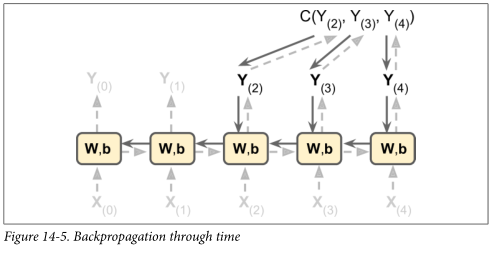

就像常规的反向传播一样

* 首先向前通过展开的网络（由虚线箭头表示）;
* 然后使用成本函数评估输出序列：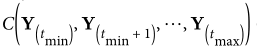

 
（其中$t_{min}$ 和$ t_{max}$ 是第一个和最后一个输出时间步，不计算忽略的输出），并且该成本函数的梯度通过展开的网络向后传播（由实线箭头表示）;

* 最后使用BPTT期间计算的梯度更新模型参数。

请注意，梯度向后流经成本函数使用的所有输出，而不仅仅是通过最终的输出（例如，在图14-5中，使用网络的最后三个输出$Y_{(2)}$计算成本函数， $Y_{(3)}$和 $Y_{(4)}$，因此梯度流过这三个输出，但不通过 $Y_{(0)}$和 $Y_{(1)}$。

* 此外，由于在每个时间步长使用相同的参数 $W$ 和 $b$ ，因此反向传播将做正确的事情并累加所有时间步。

## 3.1 Training a sequence classifier - 训练序列分类器


让我们训练一个RNN来分类MNIST图像。卷积神经网络更适合图像分类（见第13章），但这是一个你已经熟悉的简单例子。我们**将每个图像视为28行每行28个像素的序列（因为每个MNIST图像是28×28像素）**。

我们将使用
* 150个递归神经元的细胞，
* 加上一个完全连接层，其中包含10个神经元（每个类别一个）连接到最后一个时间步的输出，
* 然后是softmax层（见图14-6）。

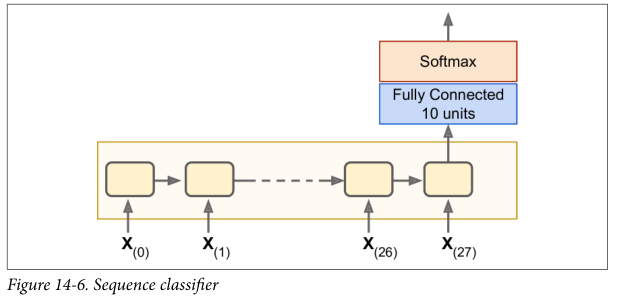

**构建阶段**非常简单;它与我们在第10章中构建的MNIST分类器几乎相同，**只是展开的RNN替换了隐藏层**。

* 请注意，完全连接的层连接到状态张量，它仅包含RNN的最终状态（即第28个输出）。
* 另请注意，$y$ 是目标类的占位符。

注意：本书使用`tensorflow.contrib.layers.fully_connected（）`而不是`tf.layers.dense（）`（本章编写时不存在）。
现在最好使用`tf.layers.dense（）`，因为contrib模块中的任何内容都可能更改或删除，恕不另行通知。

`dense（）`函数几乎与`fully_connected（）`函数相同。 与本章相关的主要差异是：

* 几个参数被重命名：`scope` 变为 `name`, `activation_fn` 变为 `activation` (类似地 `_fn` 后缀从其他参数中删除，例如 `normalizer_fn`), `weights_initializer` 变为 `kernel_initializer`, etc.
* 默认的 `activation` 现在是 `None` 而不是 `tf.nn.relu`.

In [32]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

现在让我们加载MNIST数据并将测试数据**重新整形**为[batch_size，n_steps，n_inputs] 正如网络所期望的那样。
我们将在一瞬间处理重塑训练数据的工作。


In [33]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


现在我们准备训练RNN了。


**执行阶段**与第10章中的MNIST分类器完全相同，**只是我们在将每个训练批次提供给网络之前重新整形**。

In [34]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94666666 Test accuracy: 0.9366
1 Train accuracy: 0.96666664 Test accuracy: 0.9488
2 Train accuracy: 0.9533333 Test accuracy: 0.9574
3 Train accuracy: 0.96 Test accuracy: 0.9653
4 Train accuracy: 0.96 Test accuracy: 0.9628
5 Train accuracy: 0.97333336 Test accuracy: 0.9693
6 Train accuracy: 0.9866667 Test accuracy: 0.9734
7 Train accuracy: 0.97333336 Test accuracy: 0.9689
8 Train accuracy: 0.93333334 Test accuracy: 0.9685
9 Train accuracy: 0.98 Test accuracy: 0.9701
10 Train accuracy: 0.9866667 Test accuracy: 0.9725
11 Train accuracy: 0.98 Test accuracy: 0.9751
12 Train accuracy: 0.9866667 Test accuracy: 0.9749
13 Train accuracy: 0.98 Test accuracy: 0.9674
14 Train accuracy: 0.97333336 Test accuracy: 0.9709
15 Train accuracy: 0.9866667 Test accuracy: 0.9685
16 Train accuracy: 0.9866667 Test accuracy: 0.9771
17 Train accuracy: 0.99333334 Test accuracy: 0.9758
18 Train accuracy: 0.96666664 Test accuracy: 0.9574
19 Train accuracy: 0.97333336 Test accuracy: 0.9744
20 Tra

我们的准确率超过98％ - 不错！此外，通过
* 调整超参数，
* 使用 He initialization初始化RNN权重，
* 训练更长时间或添加一些正则化（例如，丢失），

你肯定会得到更好的结果。


你可以通过将其构造代码包装在变量范围中来为RNN指定初始值设定项
（例如，使用`variable_scope（“rnn”，initializer = variance_scaling_ini tializer（））`来使用He初始化）。

### 3.1. 1 Multi-layer RNN -  多层RNN

In [37]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [38]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)

outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [39]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [40]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.9266667 Test accuracy: 0.9456
1 Train accuracy: 0.9866667 Test accuracy: 0.9647
2 Train accuracy: 0.94666666 Test accuracy: 0.9663
3 Train accuracy: 0.98 Test accuracy: 0.9757
4 Train accuracy: 0.98 Test accuracy: 0.9724
5 Train accuracy: 0.9866667 Test accuracy: 0.9785
6 Train accuracy: 0.9866667 Test accuracy: 0.9692
7 Train accuracy: 1.0 Test accuracy: 0.981
8 Train accuracy: 0.99333334 Test accuracy: 0.9788
9 Train accuracy: 0.99333334 Test accuracy: 0.9809


## 3.2  Training to Predict Time Series - 预测时间序列的训练

现在让我们来看看**如何处理时间序列**，如股票价格，气温，脑波模式等。

在本节中，我们**将训练RNN来预测生成的时间序列中的下一个值**。每个训练实例是从时间序列中随机选择的20个连续值的序列，并且目标序列与输入序列相同，除了它向前移动一个时间步（见图14-7，即下图）。

In [35]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


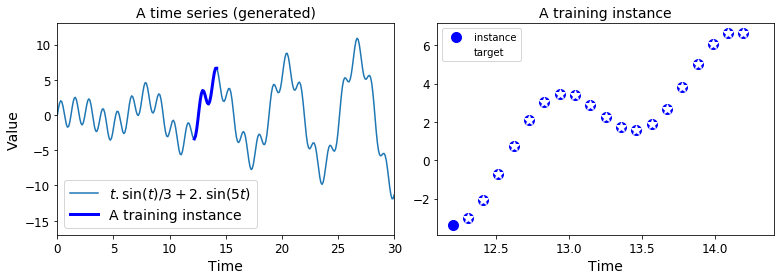

In [36]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [37]:
X_batch, y_batch = next_batch(1, n_steps)

In [38]:
np.c_[X_batch[0], y_batch[0]]

array([[-4.50341339, -4.14236382],
       [-4.14236382, -3.92870702],
       [-3.92870702, -4.0488651 ],
       [-4.0488651 , -4.59566362],
       [-4.59566362, -5.54426493],
       [-5.54426493, -6.75703201],
       [-6.75703201, -8.0161452 ],
       [-8.0161452 , -9.07599852],
       [-9.07599852, -9.72255772],
       [-9.72255772, -9.82515641],
       [-9.82515641, -9.36805638],
       [-9.36805638, -8.45405093],
       [-8.45405093, -7.27923294],
       [-7.27923294, -6.08510771],
       [-6.08510771, -5.09977511],
       [-5.09977511, -4.48258027],
       [-4.48258027, -4.28578062],
       [-4.28578062, -4.44260919],
       [-4.44260919, -4.78464929],
       [-4.78464929, -5.08425773]])

### 3.2.1  使用 `OuputProjectionWrapper`

**首先，让我们创建RNN**。

它将
* 包含100个递归神经元，我们将在20个时间步骤中展开它，因为每个训练实例将长达20个输入。
* 每个输入只包含一个特征（当时的值）。
* 目标也是20个输入的序列，每个输入包含单个值。

代码与之前几乎相同：


In [39]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

通常，你将拥有多个输入特征。 例如，如果你尝试预测股票价格，则每个时间步骤可能会有许多其他输入特征，例如竞争股票的价格，分析师的评级或可能有助于系统进行预测的任何其他特征。


**在每个时间步，我们现在有一个大小为100的输出向量。但我们真正想要的是每个时间步的单个输出值**。

最简单的解决方案是将单元格包装在`OutputProjectionWrapper`中。单元包装器的作用类似于普通单元，代理对底层单元的每个方法调用，但它也添加了一些功能。

* `OutputProjectionWrappe`r添加一个完全连接的线性神经元层（即，没有任何激活功能）在每个输出的顶部（但它不影响单元状态）。

* 所有这些完全连接的层共享相同（可训练）的权重和偏差项。

得到的RNN如图14-8所示。

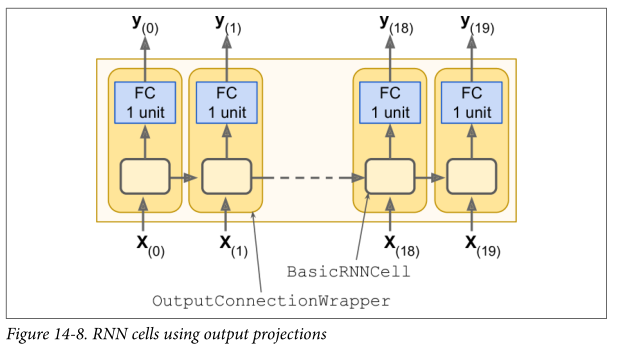

In [40]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

包装一个细胞非常容易。让我们通过将`BasicRNNCell`包装到`OutputProjectionWrapper`中来调整前面的代码


In [41]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [42]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

到现在为止还挺好。 
* 现在我们需要定义成本函数。我们将使用均方误差（MSE），就像我们在之前的回归任务中所做的那样。
* 接下来，我们将像往常一样创建一个**Adam优化器，训练操作和变量初始化操作**：


In [43]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [44]:
saver = tf.train.Saver()

现在进入**执行阶段**：

In [45]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 18.917652
100 	MSE: 0.7638619
200 	MSE: 0.29141092
300 	MSE: 0.14953335
400 	MSE: 0.07801852
500 	MSE: 0.06741312
600 	MSE: 0.061780013
700 	MSE: 0.05644042
800 	MSE: 0.05563546
900 	MSE: 0.05248669
1000 	MSE: 0.05410226
1100 	MSE: 0.051665418
1200 	MSE: 0.043779626
1300 	MSE: 0.054088768
1400 	MSE: 0.046271216


训练模型后，你可以进行预测：

In [46]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [47]:
y_pred

array([[[-3.4279    ],
        [-2.4557006 ],
        [-1.2018279 ],
        [ 0.73552984],
        [ 2.2764685 ],
        [ 3.1455982 ],
        [ 3.474099  ],
        [ 3.284229  ],
        [ 2.8162458 ],
        [ 2.2333677 ],
        [ 1.693723  ],
        [ 1.5628192 ],
        [ 1.9510182 ],
        [ 2.7644699 ],
        [ 3.8868535 ],
        [ 5.178607  ],
        [ 6.095325  ],
        [ 6.650473  ],
        [ 6.655245  ],
        [ 6.104296  ]]], dtype=float32)

Saving figure time_series_pred_plot


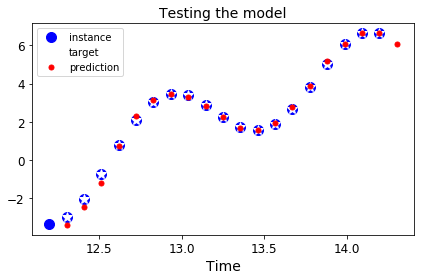

In [48]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

图14-9（即上图）显示了我们之前查看的实例的预测序列（在图14-7中），经过1,000次训练迭代后

### 3.2.2  不使用 `OutputProjectionWrapper`

虽然使用`OutputProjectionWrapper`是将RNN输出序列的维数降低到每个时间步长（每个实例）只有一个值的最简单的解决方案，但它不是最有效的。

有一个更棘手但更有效的解决方案：

* 你可以将`[batch_size，n_steps，n_neurons]`的RNN输出重新整形为`[batch_size * n_steps，n_neurons]`，


* 然后应用具有适当输出大小的单个完全连接的层（在我们的例子中只是1），这将导致输出张量的形状为
`[batch_size * n_steps，n_outputs]`，


* 然后将此张量重新整形为`[batch_size，n_steps，n_outputs]`。 

这些操作如图14-10所示。

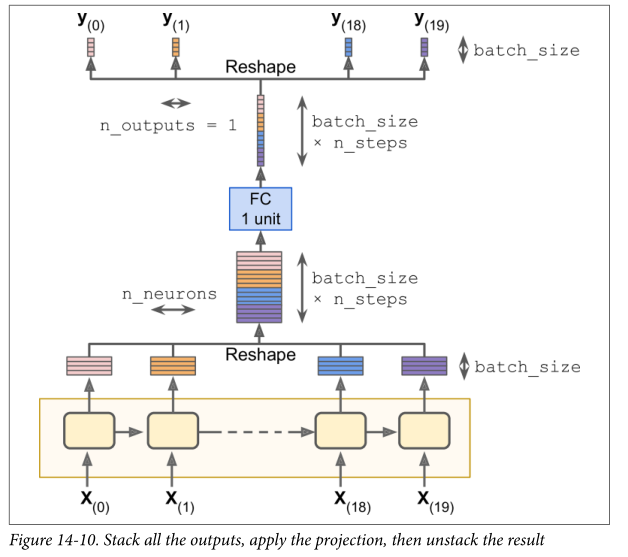

In [49]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

要实现此解决方案，我们**首先恢复到基本单元格，没有`OutputProjectionWrapper`**：


In [50]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [51]:
n_outputs = 1
learning_rate = 0.001

* 然后我们使用`reshape（）`操作堆叠所有输出，
* 应用完全连接的线性层（不使用任何激活功能;这只是一个投影），
* 最后使用`reshape（）`取消堆叠所有输出：



In [52]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

**其余代码与之前相同。这可以提供显着的速度提升，因为只有一个完全连接的层而不是每个时间步骤一个。**

In [53]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [54]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 10.162243
100 	MSE: 0.40797806
200 	MSE: 0.11557657
300 	MSE: 0.06990327
400 	MSE: 0.0678926
500 	MSE: 0.062285226
600 	MSE: 0.05683932
700 	MSE: 0.05006672
800 	MSE: 0.051020812
900 	MSE: 0.050616644
1000 	MSE: 0.0496896
1100 	MSE: 0.05061523
1200 	MSE: 0.045264535
1300 	MSE: 0.048696507
1400 	MSE: 0.042428702


In [55]:
y_pred

array([[[-3.4072816 ],
        [-2.4307933 ],
        [-1.0860796 ],
        [ 0.75661945],
        [ 2.1942704 ],
        [ 3.0227084 ],
        [ 3.3987432 ],
        [ 3.3738809 ],
        [ 2.8497932 ],
        [ 2.2291818 ],
        [ 1.6699818 ],
        [ 1.5059537 ],
        [ 1.8755245 ],
        [ 2.7538748 ],
        [ 3.961697  ],
        [ 5.136454  ],
        [ 6.0961623 ],
        [ 6.6670923 ],
        [ 6.621248  ],
        [ 6.0411973 ]]], dtype=float32)

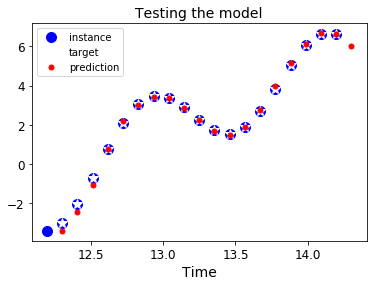

In [56]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## 3.3 Generating a creative new sequence(Creative RNN) - 生成创意新序列

既然我们有一个可以预测未来的模型，我们就可以用它来生成一些创意序列，如本章开头所述。

我们所需要的只是
* 为它提供一个包含n_steps值（例如，满零）的种子序列，
* 使用该模型预测下一个值，
* 将该预测值附加到序列，
* 将最后的n_steps值提供给模型以预测下一个 价值，

等等。 此过程生成一个与原始时间序列有一些相似之处的新序列（参见图14-11）。

In [57]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


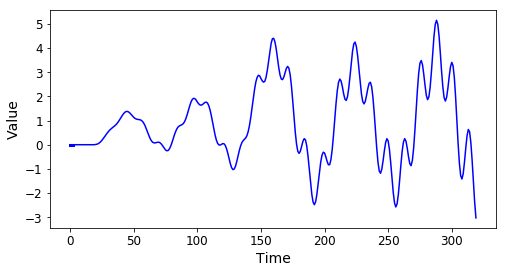

In [58]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


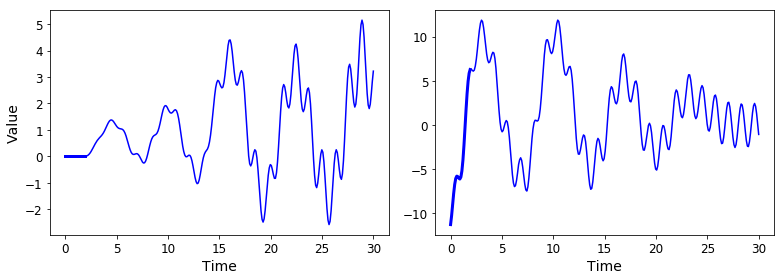

In [59]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

现在，你可以尝试将所有John Lennon专辑提供给RNN并查看是否可以生成下一个“想象”。

然而，你可能需要一个更强大的RNN，更多的神经元，也更深。 我们现在来看看**深度RNN**。


# 4. Deep RNN

堆叠多层单元是很常见的，如图14-12所示。这为你提供了深度RNN。

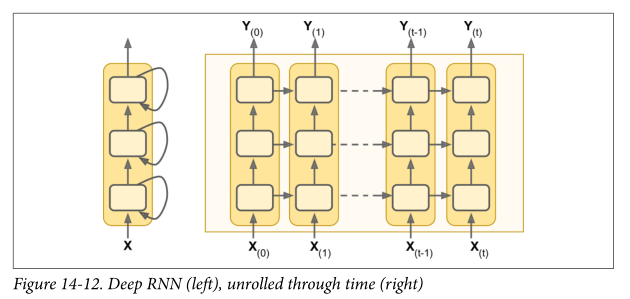

## MultiRNNCell

In [60]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

要在TensorFlow中实现深度RNN，你可以创建多个单元并将它们堆叠到`MultiRNNCell`中。在下面的代码中，我们**堆叠了三个相同的单元格**（但**你可以很好地使用具有不同数量神经元的各种单元格**）：

In [61]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

这就是需要完成深度RNN所需的一切了！

* states变量是一个元组，每层包含一个张量，每个张量代表该层单元格的最终状态（形状为[batch_size，n_neu rons]）。

* 如果在创建`MultiRNNCell`时设置`state_is_tuple = False`，则状态变为单个张量，其包含来自每个层的状态，沿着列轴连接（即，其形状为[batch_size，n_layers * n_neurons]）。

请注意，在TensorFlow 0.11.0之前，此行为是默认行为。

In [62]:
init = tf.global_variables_initializer()

In [63]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [64]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [65]:
outputs_val.shape

(2, 5, 100)

## 4.1 Distributing a Deep RNN Across Multiple GPUs - 跨多个GPU分布深度RNN

第12章指出通过**将每个层固定到不同的GPU**，我们可以跨多个GPU有效地分配深度RNN（参见图12-16）。
但是，如果你尝试在不同的`device（）`块中创建每个单元格，它将无法工作：

Do **NOT** do this:

In [72]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

失败是因为`BasicRNNCell`是一个单元工厂，而不是一个单元本身（如前所述）; 创建工厂时不会创建单元格，因此也没有变量。设备块被简单地忽略了。 单元实际上是后来创建的。

* 当你调用`dynamic_rnn（）`时，
* `dynamic_rnn（）` 调用`MultiRNNCell`，
* `MultiRNNCell`调用每个单独的`BasicRNNCell`，
* `BasicRNNCell`创建实际的单元格（包括它们的变量）。

不幸的是，这些类都没有提供任何方法来控制创建变量的设备。如果你尝试将`dynamic_rnn（）`调用放在设备块中，则整个RNN将固定到单个设备。 

所以你被卡住了吗？ 幸运的是没有！ **诀窍是创建自己的单元格包装器**：

你需要一个`DeviceCellWrapper`:

In [66]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [67]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

这个包装器只是代理每个方法调用到另一个单元格，除了它在设备块中包装`__call __（）`函数 。
现在，你可以在不同的GPU上分发每个层：

In [68]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

不要设置state_is_tuple = False，否则MultiRNNCell会在单个GPU上将所有单元状态连接成单个张量。

或者，从TensorFlow 1.1开始，你可以使用`tf.contrib.rnn.DeviceWrapper`类（自TF 1.2以来别名`tf.nn.rnn_cell.DeviceWrapper`）。

In [69]:
init = tf.global_variables_initializer()

In [70]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[ 0.06828325 -0.11375451  0.06424566 ... -0.24244198 -0.04821674
   -0.12077257]
  [ 0.07453813 -0.2251049   0.20471548 ... -0.14811224 -0.0922538
   -0.04429063]
  [ 0.13780868 -0.14680631 -0.0095655  ... -0.08136044  0.07381541
   -0.03125775]
  ...
  [-0.25400278 -0.3207855   0.39923593 ... -0.26669216  0.3350577
   -0.03757669]
  [ 0.22596692 -0.09880773 -0.27422303 ... -0.13385999 -0.25443044
   -0.36498186]
  [ 0.1655937  -0.33435836  0.34313348 ... -0.36904442  0.06908746
    0.46574104]]

 [[ 0.00489879 -0.03151967  0.02628033 ... -0.19341362 -0.0730375
    0.00451888]
  [ 0.03073939 -0.0579551   0.17785911 ... -0.20945786  0.05200011
   -0.07436937]
  [ 0.00192378 -0.25690764  0.12488247 ...  0.02644884 -0.25046453
   -0.12239399]
  ...
  [-0.13501379 -0.06209698  0.1595035  ... -0.2001212  -0.3338365
   -0.09281697]
  [-0.44347292  0.2032327   0.1252696  ... -0.07962411  0.27046496
    0.3188401 ]
  [ 0.23965777 -0.22903362  0.07749593 ... -0.02653922  0.084024
    0.023136

## 4.2 Applying Dropout

如果你构建一个非常深的RNN，它可能最终过度拟合训练集。为了防止这种情况，一种常见的技术是应用Dropout（在第11章中介绍）。 

* 你可以像往常一样在RNN之前或之后简单地添加一个dropout层，
* 但如果你还想在RNN层之间应用dropout，则需要使用DropoutWrapper。 

以下代码将dropout应用于RNN中每个层的输入，以50％的概率丢弃每个输入：

注意也可以通过设置`put_keep_prob`将`dropout`应用于输出。

这段代码的主要问题是它不仅会在训练期间应用应用`dropout`，而且在测试期间也会应用`dropout`，这不是你想要的（回想一下，只有在训练期间才应用应用`dropout`）。

不幸的是，`DropoutWrapper`不支持`is_training`占位符（但是？），所以你必须编写自己的dropout包装类，或者有两个不同的图：一个用于训练，另一个用于测试。 第二个选项如下所示：
```python
import sys
is_training = (sys.argv[-1] == "train")

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
if is_training:
    cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([cell] * n_layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
[...] # build the rest of the graph
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            [...] # train the model
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        [...] # use the model
```

With that you should be able to train all sorts of RNNs! 

In [71]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [72]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

注意：`input_keep_prob`参数可以是占位符，可以将其设置为训练期间所需的任何值，并在测试期间将其设置为1.0（有效地关闭丢失）。

这是一个比本书早期版本推荐的更优雅的解决方案（即编写自己的包装类或具有单独的模型进行训练和测试）。 感谢Shen Cheng引起我的注意。

In [73]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [74]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [75]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 14.964676
100 Training MSE: 4.7225266
200 Training MSE: 3.5869753
300 Training MSE: 3.570032
400 Training MSE: 2.830784
500 Training MSE: 2.6746242
600 Training MSE: 3.205743
700 Training MSE: 3.8643434
800 Training MSE: 4.6368446
900 Training MSE: 3.1709585
1000 Training MSE: 2.7892573
1100 Training MSE: 3.4393764
1200 Training MSE: 3.675533
1300 Training MSE: 3.2392366
1400 Training MSE: 3.9285464


In [76]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


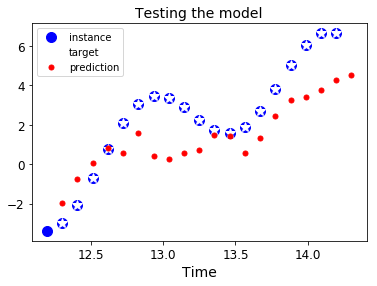

In [77]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

哎呀，在这种特殊情况下，Dropout似乎根本没有帮助。：/

不幸的是，如果你想在长序列上训练RNN，事情会变得更难。 让我们看看为什么以及你可以做些什么。

## 4.3  The Difficulty of Training over Many Time Steps - 多时间训练的难度

要在长序列上训练RNN，你需要在很多时间步长上运行它，使展开的RNN成为一个非常深的网络。就像任何深度神经网络一样，它可能会受到梯度消失/爆炸问题的困扰（在第11章中讨论）并需要永远训练。

我们讨论的用于缓解此问题的许多技巧也可用于深度展开的RNN：
* 良好的参数初始化，
* 非饱和激活函数（例如，ReLU），
* 批量标准化，
* 梯度剪切
* 和更快的优化器。

然而，如果RNN需要处理甚至中等长度的序列（例如，100个输入），则训练仍然将非常慢。


解决此问题的最简单和最常见的解决方案是**在训练期间仅在有限的时间步长内展开RNN**。这称为**截断反向传播**。在TensorFlow中，你可以通过截断输入序列来实现它。例如，在时间序列预测问题中，你只需在训练期间减少`n_steps`。当然，问题在于该模型无法学习长期模式。

一种解决方法可以是确保这些缩短的序列包含旧的和最近的数据，以便模型可以学习使用两者（例如，序列可以包含过去五个月的月度数据，然后是过去五周的每周数据 ，然后是过去五天的每日数据）。

但是这种解决方法有其**局限性**：如果来自去年的**细粒度 - fine-grained** 数据实际上有用呢？如果有一个短暂但重要的事件，即使在几年之后（例如，选举结果），也必须考虑到这一事件，该怎么办？

除了训练时间长，长期运行的RNN面临的第二个问题是**第一个输入的记忆逐渐消失**。实际上，由于数据在遍历RNN时经历的变换，一些信息在每个时间步之后丢失。过了一会儿，RNN的状态几乎没有包含第一个输入的痕迹。这可能是一个停滞不前。

例如，假设你想要对以“I loved this movie”这四个词开头的长期评论进行情绪分析，但其余的评论列出了可能使电影更好的许多内容。如果RNN逐渐忘记前四个单词，它将完全误解审查。为了解决这个问题，已经引入了具有长期记忆的各种类型的细胞。
它们已经证明非常成功，基本细胞不再使用了。 让我们首先看看这些长存储单元中最受欢迎的：**LSTM细胞**。

# 5. LSTM Cell - 长短期记忆

**长短期记忆（LSTM）**细胞由Sepp Hochreiter和JürgenSchmidhuber于1997年提出，多年来由Alex Graves，HaşimSak，Wojciech Zaremba等研究人员逐渐改进。

如果你认为LSTM单元是一个黑盒子，它可以像一个基本单元一样使用，除了它会表现得更好;
* 训练将更快地收敛，
* 它将检测数据中的长期依赖性。

在TensorFlow中，你只需使用`BasicLSTM Cell`而不是`BasicRNNCell`

```python
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
```

LSTM细胞管理两个状态向量，出于性能原因，默认情况下它们是分开的。你可以通过在创建`BasicLSTMCell`时设置`state_is_tuple = False`来更改此默认行为。

那么LSTM细胞如何工作？基本LSTM单元的架构如图14-13所示。

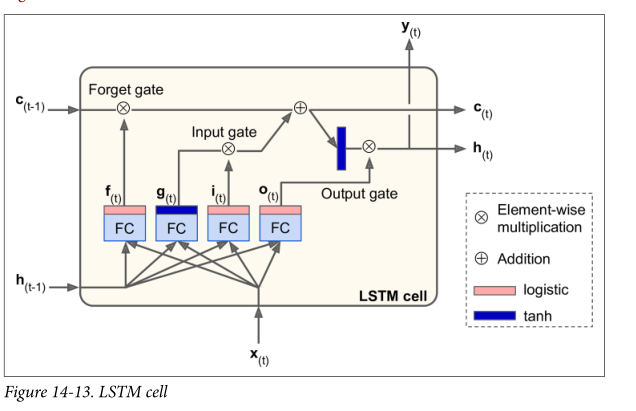

如果你不看框内的内容，LSTM单元看起来就像常规单元一样,除了它的状态被分成两个向量之外：$h_{(t)}$和 $c_{(t)}$（“c”代表“cell”）。你可以**将$h_{(t)}$视为短期状态，将 $c_{(t)}$ 视为长期状态**。

现在让我们打开盒子吧！核心思想是：**网络可以了解在长期状态下存储什么，丢弃什么以及从中读取什么**。

* 由于长期状态 $c_{(t-1)}$ 从左到右穿过网络，你可以看到它首先通过一个遗忘门，丢弃了一些记忆，然后通过加法操作增加了一些新记忆。（它添加了由输入门选择的记忆）。


* 结果 $c_{(t)}$ 直接发送，没有任何进一步的转换。因此，在每个时间步，一些记忆被删除，一些记忆被添加。

* 此外，在加法运算之后，长期状态被复制并通过$tanh$函数，然后结果被输出门过滤。这产生短期状态：$h_{(t)}$（其等于该时间步长：$y_{(t)}$的单元输出）。

现在让我们来看看新记忆的来源以及大门的工作方式。


首先，当前输入向量 $x_{(t)}$ 和先前的短期状态 $h_{(t-1)}$ 被投喂到到四个不同的完全连接的层。它们都有不同的用途：

1. 主层是输出$g_{(t)}$的层。它具有分析当前输入 $x_{(t)}$ 和先前（短期）状态 $h_{(t-1)}$ 的通常作用。在基本单元格中，除了这一层之外别无其他，它的输出直接输出到：$y_{(t)}$和 $h_{(t)}$。相反，在LSTM单元格中，此图层的输出不会直接输出，而是部分存储在长期状态中。



2. 其他三个层是**门控制器**。由于它们使用逻辑激活函数，因此它们的输出范围为0到1。正如你所看到的，它们的输出被投喂到逐元素乘法运算，因此如果它们输出 0 ，它们将关闭门，如果它们输出 1 ，则它们打开它。特别：

   * 遗忘门（由$f_{(t)}$ 控制）控制长期状态的哪些部分应该被擦除。

   * 输入门（由$i_{(t)}$ 控制）控制$g_{(t)}$的哪些部分应加到长期状态（这就是为什么我们说它只是“部分存储”）。

   * 最后，输出门（由$o_{(t)}$控制）控制长时状态的哪个部分应该在此时间步读取（输出到$h_{(t)}$和$y_{(t)}$。

简而言之，**LSTM单元可以学习识别一个重要的输入（这是输入门的作用），将其存储在长期状态，学会在需要时保留它（这就是遗忘门的作用）， 并学习在需要时提取它**。这就解释了为什么他们在捕捉时间序列，长文本，录音等长期模式方面取得了惊人的成功。

公式14-3总结了如何计算单元的长期状态，短期状态，以及单个实例的每个时间步的输出（所有小批量的方程非常相似）。

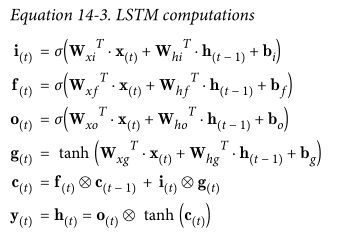

* $W_{xi}，W_{xf}，W_{xo}，W_{xg}$ 是四个层中的每一个的权重矩阵，用于它们与输入向量 $x_{(t)}$ 的连接。


* $W_{hi}，W_{hf}，W_{ho}和W_{hg}$ 是四层中每一层的权重矩阵，它们与先前的短期状态 $h_{(t-1)}$的连接。


* $b_i，b_f，b_o和b_g $是四层中每一层的偏置项。

请注意，TensorFlow将 $b_f$ 初始化为一个全是1而不是0的向量。这可以防止在训练开始时遗忘一切。

In [78]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [79]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [80]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [81]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [82]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.9533333 Test accuracy = 0.9479
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9696
Epoch 2 Train accuracy = 0.96666664 Test accuracy = 0.9759
Epoch 3 Train accuracy = 0.98 Test accuracy = 0.9812
Epoch 4 Train accuracy = 0.97333336 Test accuracy = 0.9835
Epoch 5 Train accuracy = 0.99333334 Test accuracy = 0.9816
Epoch 6 Train accuracy = 0.9866667 Test accuracy = 0.9865
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9845
Epoch 8 Train accuracy = 0.99333334 Test accuracy = 0.9822
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9842


In [83]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [84]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

## 5.1 Peephole Connections - 窥视孔连接

在基本LSTM单元中，门控制器只能看到输入 $x_{(t)}$和前一个短期状态 $h_{(t-1)}$。通过让他们看一下长期状态来给他们更多的背景可能是一个好主意。这个想法是由Felix Gers和JürgenSchmidhuber于2000年提出的。

他们提出了一种带有额外连接的LSTM变体，称为**窥视孔连接**：

* 将前一个长期状态 $c_{(t-1)}$作为输入添加到遗忘门和输入门的控制器，

* 并且将当前长期状态 $c_{(t)}$作为输入添加到输出门的控制器。

要在TensorFlow中实现窥视孔连接，必须使用`LSTMCell`而不是`BasicLSTMCell`并设置`use_peepholes = True`：
```python
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)
```

LSTM细胞还有许多其他变种。一个特别受欢迎的变种是**GRU单元格**，我们现在看一下。

# 6. GRU Cell

**The Gated Recurrent Unit - 门控递归单元**（GRU）细胞（见图14-14）由Kyunghyun Cho等人在2014年的论文中提出。 论文还介绍了我们前面提到的编码器 - 解码器网络。

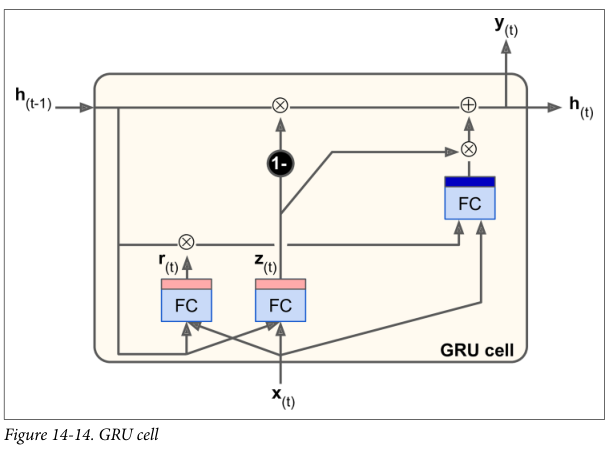

GRU单元是LSTM单元的简化版本，它似乎表现得同样好（这解释了它越来越受欢迎）。 主要简化是：

* 两个状态向量合并为单个向量 $h_{(t)}$。
* 单个门控制器控制遗忘门门和输入门。如果门控制器输出1，则输入门打开，遗忘门关闭。如果输出0，则相反。 换句话说，每当必须存储a memory 时，首先擦除存储它的位置。 这实际上是LSTM细胞本身的常见变体。
* 没有输出门; 每个时间步输出满状态向量。但是，有一个新的门控制器可以控制先前状态的哪个部分将显示在主层。

公式14-4总结了如何计算单个实例的每个时间步的单元状态。

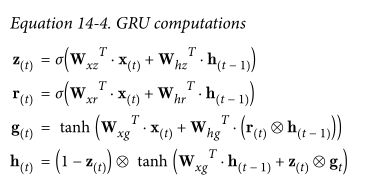

在TensorFlow中创建GRU单元是很简单的：
```python
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

```
LSTM或GRU细胞是近年来RNN成功背后的主要原因之一，特别是在**自然语言处理（NLP）**中的应用。

# 7. Natural Language Processing - 自然语言处理

大多数最先进的NLP应用程序，例如**机器翻译，自动摘要，解析，情感分析**等，现在都是（至少部分地）基于RNN的。在最后一节中，我们将快速了解机器翻译模型的外观。

TensorFlow强大的`Word2Vec`和`Seq2Seq`教程很好地介绍了这个主题，所以你一定要查看它们。


## 7.1  Word Embeddings - 词嵌入

在开始之前，我们需要选择一个单词表示。

一种选择可以是使用单热矢量来表示每个单词。 假设你的词汇表包含50,000个单词，那么第n个单词将被表示为50,000维向量，除了第n个位置的1之外，其全部为0。

然而，如此庞大的词汇表，这种稀疏表示根本就没有效率。 理想情况下，你希望类似的单词具有相似的表示形式，使模型可以轻松地将所学单词的内容概括为所有相似的单词。

例如，如果模型被告知“我喝牛奶”是一个有效的句子，并且如果它知道“牛奶”接近“水”但远离“鞋子”，然后它会知道“我喝水”也可能是一个有效的句子，而“我喝鞋子”可能不是。 但是你怎么能想出这样一个有意义的代表呢？



最常见的解决方案是**使用相当小且密集的矢量（例如，150维）来表示词汇表中的每个单词**，称为**嵌入**，并且让神经网络在训练期间学习每个单词的良好嵌入。

在训练开始时，嵌入只是随机选择，但在训练期间，反向传播会自动移动嵌入，以帮助神经网络执行其任务。通常这意味着相似的词会逐渐彼此靠近，甚至最终以一种相当有意义的方式组织起来。例如，嵌入可能最终沿着代表性别，单数/复数，形容词/名词等的各种轴放置。结果真的很棒。

在TensorFlow中，**首先需要为词汇表中的每个单词创建表示嵌入的变量（随机初始化）：**

```python
vocabulary_size = 50000
embedding_size = 150
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
```

**现在假设你想要将“我喝牛奶”这句话提供给你的神经网络**。你应首先预处理该句子并将其分解为已知单词列表。

例如，你可以删除不必要的字符，
* 用预定义的标记字替换未知单词，例如“[UNK]”，
* 用“[NUM]”替换数值，
* 用“[URL]”替换URL，依此类推。

获得已知单词列表后，你可以在字典中查找每个单词的整数标识符（从0到49999），例如[72,3335,288]。

此时，你已准备好使用占位符将这些单词标识符提供给TensorFlow，并应用embedding_lookup（）函数来获取相应的嵌入：
```python
train_inputs = tf.placeholder(tf.int32, shape=[None]) # from ids...
embed = tf.nn.embedding_lookup(embeddings, train_inputs) # ...to embeddings

```

一旦你的模型学会了好的嵌入词，它们实际上可以在任何NLP应用中相当有效地重复使用：毕竟，无论你的应用是什么，“牛奶”仍然接近“水”而远离“鞋子”。

实际上，你可能希望下载预训练的单词嵌入，而不是训练自己的单词嵌入。就像重新使用预训练图层一样（参见第11章），你可以选择冻结预训练的嵌入（例如，使用`trainable = False`创建`embeddings`变量）或者让反向传播根据你的应用调整它们。

* 第一个选项将加快训练速度，
* 但第二个选项可能会导致性能稍高。

嵌入对于表示可以采用大量不同值的分类属性也很有用，尤其是当值之间存在复杂的相似性时。例如，考虑职业，爱好，菜肴，品种，品牌等。



This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

### 7.1.1  Fetch the data - 获取数据

In [88]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [ ]:
words = fetch_words_data()

In [94]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

### 7.1.2  Build the dictionary - 建立字典

In [95]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [96]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [97]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [98]:
words[24], data[24]

('culottes', 0)

### 7.1.3  Generate batches - 生成批次

In [99]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [100]:
np.random.seed(42)

In [101]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [102]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [103]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

### 7.1.4  Build the model - 建立模型

In [104]:
batch_size = 128
embedding_size = 128  # 嵌入向量的维数。
skip_window = 1       # 左右要考虑多少个单词。
num_skips = 2         # 重复使用输入生成标签的次数。

# 我们选择一个随机验证集来对最近邻居进行采样。
# 在这里，我们将验证样本限制为具有较低数字ID的单词，这也是最常见的构造。

valid_size = 16     # 用于评估相似性的随机词集。
valid_window = 100  # 仅在分布的头部选择开发样本。
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # 要抽样的负面例子数量。

learning_rate = 0.01

In [105]:
reset_graph()

# 输入数据。
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [106]:
vocabulary_size = 50000
embedding_size = 150

# 查找嵌入输入。
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [107]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [108]:
# 构造NCE损失的变量
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# 计算批次的平均NCE损失。
# 每当我们评估损失时，tf.nce_loss会自动绘制负标签的新样本。

loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# 构造Adam优化器
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# 计算minibatch示例和所有嵌入之间的余弦相似度。
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# 添加变量初始化程序。
init = tf.global_variables_initializer()

### 7.1.5  Train the model - 训练模型

In [109]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # 我们通过评估训练op来执行一个更新步骤（包括在session.run（）的返回值列表中
        # 
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # 平均损失是对过去2000批次损失的估计。
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # 请注意，这很昂贵（如果每500步计算一次，减速约20％）
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  294.812255859375
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, richards, egyptians, legionnaires, leonel, opener,
Nearest to up: clair, drives, steadfast,

让我们保存最终的嵌入（当然，如果您愿意，可以使用TensorFlow `Saver`）：

In [110]:
np.save("./my_final_embeddings.npy", final_embeddings)

### 7.1.6  Plot the embeddings -  绘制嵌入图

In [111]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

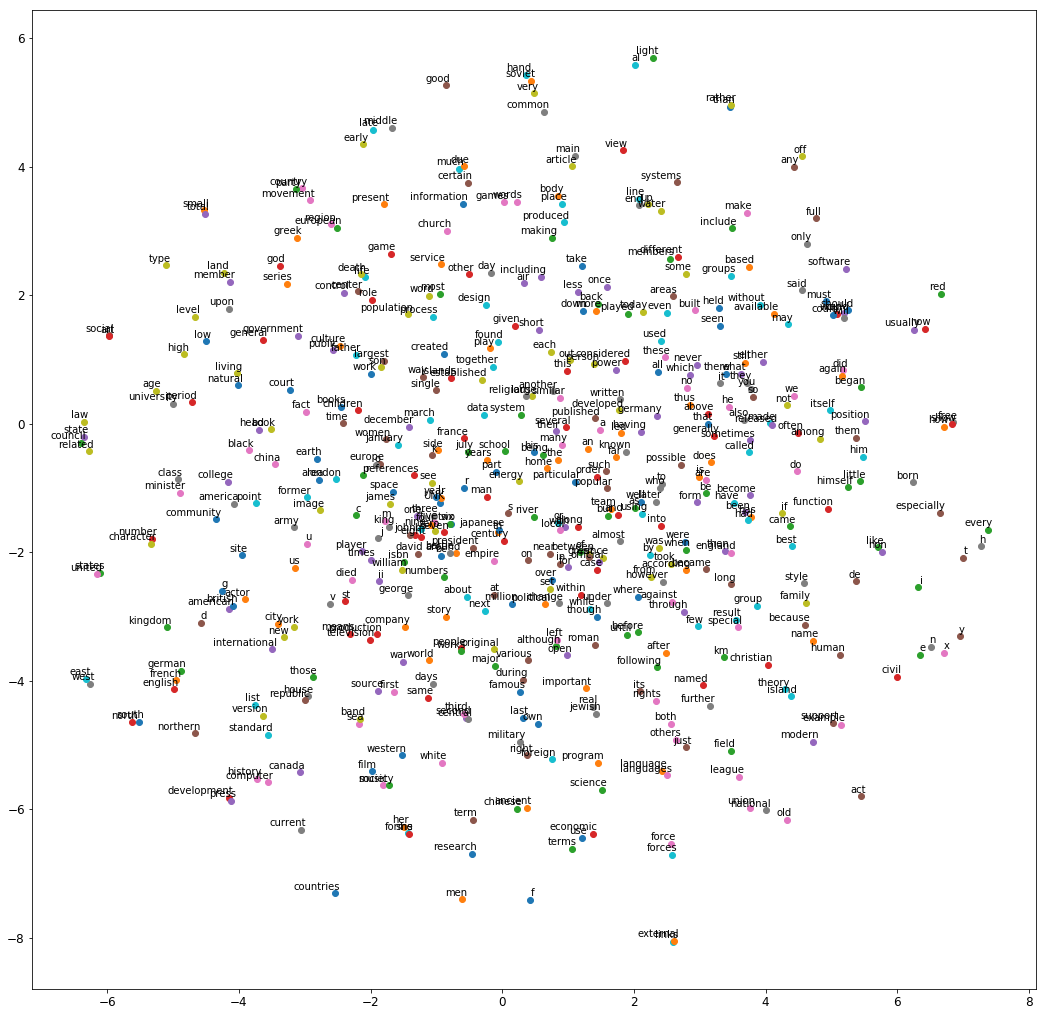

In [112]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

你现在拥有了实现机器翻译系统所需的几乎所有工具。 我们现在来看看。

## 7.2  An Encoder–Decoder Network for Machine Translation - 一种用于机器翻译的编码器 - 解码器网络

让我们来看一个简单的机器翻译模型，它将英语句子翻译成法语（见图14-15）。

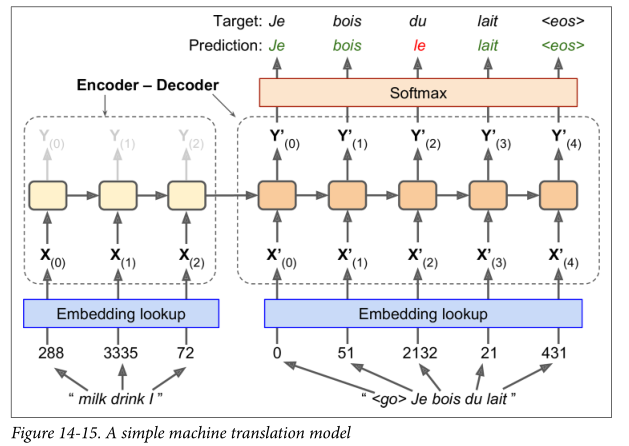

英文句子被送到编码器，解码器输出法语翻译。

* 请注意，法语翻译也用作解码器的输入，但后退一步。换句话说，解码器作为输入给出它应该在前一步骤输出的字（不管它实际输出的是什么）。对于第一个单词，给出一个表示句子开头的标记（例如，“<go>”）。期望解码器以**end-of- sequence (EOS) token ** （例如，“<eos>”）结束句子。


* 请注意，英语句子在送入编码器之前是相反的。对于例如“I drink milk”被逆转为“milk drink I”。这确保了英语句子的开头将最后投喂到编码器，这很有用，因为这通常是解码器需要翻译的第一件事。

每个单词最初由简单的整数标识符表示（例如，288表示“milk”）。接下来，嵌入查找返回词嵌入（如前所述，这是一个密集的，相当低维度的向量）。这些词嵌入是实际被投喂到编码器和解码器的内容。

在每个步骤，解码器输出输出词汇表中每个单词的分数（即法语），然后Softmax层将这些分数变成概率。例如，在第一步，单词“Je”可能具有20％的概率，“Tu”可能具有1％的概率，等等。输出是概率最高的单词。 这非常类似于常规分类任务，所以你可以使用`软max_cross_entropy_with_logits（）`函数训练模型。


请注意，在推理时间（训练后），你将没有目标句子被投喂到解码器。相反，只需向解码器提供上一步输出的字，如图14-16所示（这将需要图中未显示的嵌入查找）。

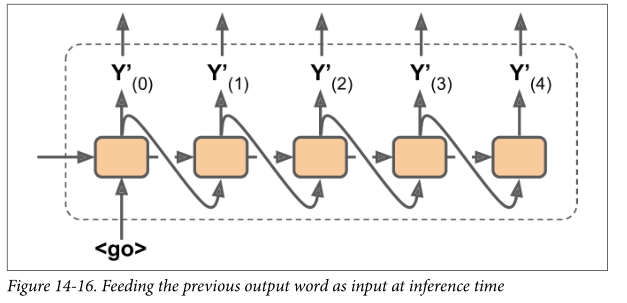

好的，现在你已经对全局有了一个了解。

然而，如果你通过TensorFlow的序列到序列教程，你看一下`rnn / translate / seq2seq_model.py`中的代码（在TensorFlow模型中），你会发现一些重要的区别：

1. 第一，到目前为止，我们假设所有输入序列（到编码器和解码器）具有恒定的长度。但显然句子长度可能不同。有几种方法可以处理 - 例如，使用`static_rnn（）`或`dynamic_rnn（）`函数的`sequence_length`参数来指定每个句子的长度（如前所述）。但是，本教程中使用了另一种方法（大概是出于性能原因）：

   * 句子被分组成相似长度的桶（例如，1到6个单词的句子，7到12个单词的句子，等等11），并且使用特殊填充标记（例如，“<pad>”)填充较短的句子。例如“I drink milk”变成“<pad> <pad> <pad>milk drink I”，它的翻译成为“Je bois du lait <eos> <pad>”。
   *  当然，我们想要忽略经过EOS token的任何输出。为此，教程的实现使用了target_weights向量。例如，对于目标子“Je bois du lait <eos> <pad>”，权重将设置为[1.0,1.0,1.0,1.0,1.0,0.0]（注意对应于目标句子中的填充标记的权重0.0）。
   * 简单地将损失乘以目标权重将使与EOS token之后的单词相对应的损失归零。

2. 第二，当输出词汇量很大时（这里就是这种情况），输出每个可能单词的概率将非常慢。如果目标词汇表包含50,000个法语单词，则解码器将输出50,000维向量，然后计算softmax函数如此大的矢量将是非常计算密集的。为了避免这种情况，一种解决方案是**让解码器输出更小的向量**，例如1,000维向量，然后使用采样技术来估计损失，而不必在目标词汇表中的每个单词上计算它。这种采样Softmax技术由SébastienJean等人于2015年引入。 在TensorFlow中，你可以使用`sampled_softmax_loss（）`函数。

3. 第三，教程的实现使用一种注意机制，让解码器窥视输入序列。增加注意力的RNN超出了本书的范围，但如果你感兴趣，可以使用注意力提供有关机器翻译，机器阅读和图像标题的有用文章。


4. 最后，本教程的实现使用了tf.nn.legacy_seq2seq模块，该模块提供了轻松构建各种编码器 - 解码器模型的工具。例如，`embedding_rnn_seq2seq（）`函数创建一个简单的编码器 - 解码器模型，自动为你处理词嵌入，就像图14-15中所示。 此代码可能会快速更新以使用新的`tf.nn.seq2seq`模块。




你现在拥有了解序列到序列教程实现所需的所有工具。 检查一下，培训自己的英语到法语的翻译！

`basic_rnn_seq2seq（）`函数创建一个简单的编码器/解码器模型：

* 它首先运行一个RNN，将encoder_inputs编码为一个状态向量，
* 然后在decoder_inputs上运行用最后一个编码器状态初始化的解码器。

编码器和解码器使用相同的RNN单元类型，但它们不共享参数。

In [113]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [114]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

## 1. to 6.

请移步我的简书[Chapter - 14 Exercise(1-6)](https://www.jianshu.com/p/29f7ac587d78)

## 7. Embedded Reber Grammars - 嵌入式Reber语法

首先，我们需要构建一个基于语法生成字符串的函数。

* 语法将表示为每个状态的可能转换列表。
* 转换指定要输出的字符串（或生成它的语法）和下一个状态。

In [91]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

让我们根据**默认的Reber语法**生成一些字符串：

In [92]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

看起来不错。 现在让我们根据**嵌入的Reber语法**生成一些字符串：

In [93]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

现在我们需要一个函数来生成不遵循语法的字符串。我们可以生成一个随机字符串，但任务有点太容易了，
所以我们将生成一个尊重语法的字符串，我们将**通过更改一个字符来破坏它**：

In [94]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

让我们看看一些损坏的字符串：

In [95]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

无法将字符串直接提供给RNN：

* 首先，我们需要将其转换为向量序列。 每个向量将使用单热编码表示单个字母。例如，字母“B”将表示为向量[1,0,0,0,0,0,0]，字母E将表示为[0,1,0,0,0,0， 0]等等。

* 让我们编写一个函数，将一个字符串转换为一个这样的单热向量序列。 请注意，如果字符串短于n_steps，则将使用零向量填充（稍后，我们将告诉TensorFlow每个字符串实际使用`sequence_length`参数的时间长度）。

In [96]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [97]:
string_to_one_hot_vectors("BTBTXSETE", 12)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

我们现在可以生成数据集，包含50％的好字符串和50％的错误字符串：

In [98]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [99]:
X_train, l_train, y_train = generate_dataset(10000)

我们来看看第一个训练实例：


In [100]:
X_train[0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0,

它填充了很多零，因为数据集中最长的字符串很长。 这个特殊的字符串有多长？

In [101]:
l_train[0]

23

它属于哪个类

In [102]:
y_train[0]

array([0])

完美！ 我们准备创建RNN来识别好的字符串。我们构建了一个非常类似于我们之前构建的序列分类器来对MNIST图像进行分类，主要有两个区别：

* 首先，输入字符串具有可变长度，因此我们需要在调用`dynamic_rnn（）`函数时指定`sequence_length`。

* 其次，这是一个二元分类器，因此我们只需要一个输出神经元，它将为每个输入字符串输出它是一个好字符串的估计对数概率。对于多元分类，我们使用`sparse_softmax_cross_entropy_with_logits（）`但是对于二元分类，我们使用`sigmoid_cross_entropy_with_logits（）`。

In [103]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

现在让我们**生成一个验证集**，以便我们可以在训练期间跟踪进度：

In [104]:
X_val, l_val, y_val = generate_dataset(5000)

In [105]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./my_reber_classifier")

   0  Train loss: 0.6700, accuracy: 68.00%  Validation accuracy: 59.60%
   1  Train loss: 0.6540, accuracy: 70.00%  Validation accuracy: 62.16%
   2  Train loss: 0.6396, accuracy: 82.00%  Validation accuracy: 64.74%
   3  Train loss: 0.5561, accuracy: 78.00%  Validation accuracy: 73.30%
   4  Train loss: 0.5061, accuracy: 78.00%  Validation accuracy: 77.58%
   5  Train loss: 0.5507, accuracy: 80.00%  Validation accuracy: 77.52%
   6  Train loss: 0.3775, accuracy: 84.00%  Validation accuracy: 84.42%
   7  Train loss: 0.5396, accuracy: 72.00%  Validation accuracy: 79.20%
   8  Train loss: 0.2918, accuracy: 88.00%  Validation accuracy: 89.88%
   9  Train loss: 0.2438, accuracy: 92.00%  Validation accuracy: 89.94%
  10  Train loss: 0.1423, accuracy: 98.00%  Validation accuracy: 96.30%
  11  Train loss: 0.0678, accuracy: 100.00%  Validation accuracy: 98.84%
  12  Train loss: 0.0463, accuracy: 100.00%  Validation accuracy: 99.26%
  13  Train loss: 0.0146, accuracy: 100.00%  Validation accura

现在让我们在两个棘手的字符串上测试我们的RNN：

* 第一个是坏的，而第二个是好的。它们只有第二个到最后一个字符不同。

* 如果RNN认为这是对的，它表明它设法注意到第二个字母应该总是等于倒数第二个字母的模式。这需要相当长的短期记忆（这就是我们使用GRU细胞的原因）。

In [106]:
test_strings = [
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "./my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba_val[index][0]))

INFO:tensorflow:Restoring parameters from ./my_reber_classifier

Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.17%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.96%


当当当！ 它工作正常。 RNN高度自信地找到了正确的答案。:)

## 8. and 9.

Coming soon...